In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import glob
from tqdm.auto import tqdm
import country_converter as coco
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-10-07 08:11:59.854 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [8]:
import polars as pl
import pandas as pd
import glob
import sys
import ipaddress
from tqdm.notebook import tqdm
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

sys.path.append('/home/service/ipinfos')
import get_ip_infos as gip

In [2]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt

In [5]:
def load_and_join(files):
    df = pl.DataFrame()
    for i in tqdm(range(len(files))):
        if df.is_empty():
            df = pl.read_parquet(files[i],columns=['saddr','classification','numsubnets'])
            df = df.group_by("saddr").agg(classifications = pl.col("classification").unique(),
                                         sumreplies = pl.col('numsubnets').sum())
            df = df.with_columns(
                pl.when((pl.col("classifications").list.contains("echoreply")) & 
                        (pl.col("classifications").list.len() == 1))
                .then(pl.lit("echoreply"))
                .when((pl.col("classifications").list.contains("echoreply")) & 
                      (pl.col("classifications").list.len() > 1))
                .then(pl.lit("ambiguous"))
                .otherwise(pl.lit("other"))
                .alias("code")
            ).drop('classifications')
            df = df.with_columns(inscan=True)
        else:
            tmp = pl.read_parquet(files[i],columns=['saddr','classification','numsubnets'])
            tmp = tmp.group_by("saddr").agg(classifications = pl.col("classification").unique(),
                                           sumreplies = pl.col('numsubnets').sum())
            tmp = tmp.with_columns(
                pl.when((pl.col("classifications").list.contains("echoreply")) & 
                        (pl.col("classifications").list.len() == 1))
                .then(pl.lit("echoreply"))
                .when((pl.col("classifications").list.contains("echoreply")) & 
                      (pl.col("classifications").list.len() > 1))
                .then(pl.lit("ambiguous"))
                .otherwise(pl.lit("other"))
                .alias("code")
            ).drop('classifications')
            tmp = tmp.with_columns(inscan=True)
            df = df.join(tmp,on=['saddr'],how='full', suffix=f'_s{i}',coalesce=True)
            
    return df

In [3]:
basedir = '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis'

files = [f'{basedir}/data/scans/zmap_icmp_bgp_netaddr_1728140292_p0',
         f'{basedir}/data/bgp48_sra_checks/zmap_icmp_bgp_48_sra_1728075185_p0',
        f'{basedir}/data/bgp48_64s_sra_checks/zmap_icmp_bgp_48only_64s_sra_1730213648_processed',
        f'{basedir}/data/scans/zmap_icmp_route6_64_1728147418_p0',
        f'{basedir}/data/tuminput_sra_checks/zmap_icmp_tum_64_sra_1731694726_p0',
]

In [6]:
df = load_and_join(files)

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
icmp_count = pl.concat([df.filter(pl.col('inscan')).group_by('code').agg(count=pl.col('sumreplies').sum()).with_columns(scan=pl.lit('BGP (Plain)')),
           df.filter(pl.col('inscan_s1')).group_by('code_s1').agg(count=pl.col('sumreplies_s1').sum()).with_columns(scan=pl.lit('BGP /48')).rename({'code_s1':'code'}),
           df.filter(pl.col('inscan_s2')).group_by('code_s2').agg(count=pl.col('sumreplies_s2').sum()).with_columns(scan=pl.lit('BGP /64')).rename({'code_s2':'code'}),
           df.filter(pl.col('inscan_s3')).group_by('code_s3').agg(count=pl.col('sumreplies_s3').sum()).with_columns(scan=pl.lit('Route6 /64')).rename({'code_s3':'code'}),
           df.filter(pl.col('inscan_s4')).group_by('code_s4').agg(count=pl.col('sumreplies_s4').sum()).with_columns(scan=pl.lit('Hitlist /64')).rename({'code_s4':'code'})
          ]).to_pandas()

In [8]:
icmp_count = icmp_count.set_index(['code', 'scan']).squeeze().unstack('scan')

In [9]:
icmp_count.index.name = None

In [10]:
icmp_count = icmp_count.reindex(['echoreply','other','ambiguous'])

In [11]:
icmp_count.index = ['Echo Reply','Error Msg.', 'Both']

In [12]:
icmp_count['BGP (Plain)'] = icmp_count['BGP (Plain)']/icmp_count['BGP (Plain)'].sum()
icmp_count['BGP /48'] = icmp_count['BGP /48']/icmp_count['BGP /48'].sum()
icmp_count['BGP /64'] = icmp_count['BGP /64']/icmp_count['BGP /64'].sum()
icmp_count['Hitlist /64'] = icmp_count['Hitlist /64']/icmp_count['Hitlist /64'].sum()
icmp_count['Route6 /64'] = icmp_count['Route6 /64']/icmp_count['Route6 /64'].sum()

In [32]:
icmp_count

scan,BGP (Plain),BGP /48,BGP /64,Hitlist /64,Route6 /64
Echo Reply,0.250907,0.024718,0.012974,0.352343,0.020947
Error Msg.,0.716094,0.874330,0.863407,0.638573,0.923501
Both,0.032999,0.100952,0.123618,0.009085,0.055553


In [33]:
#icmp_count = icmp_count[['BGP /48','BGP /64','Route(6) /64','Hitlist /64']]

In [34]:
plt.rc("font", size=12)

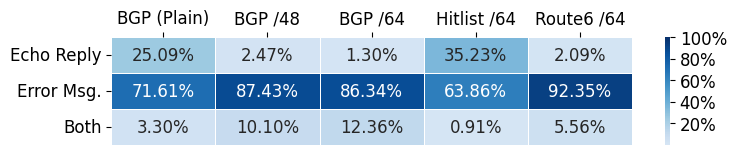

In [35]:
fig,ax = plt.subplots(figsize=(12*0.7,2*0.7))
sns.heatmap(icmp_count,vmin=0,vmax=1,cmap='Blues',center=0.4,annot=True,fmt='.2%',linewidth=.5,ax=ax)
cbar = ax.collections[0].colorbar
cbar.set_ticks([.2, .4, .6, .8, 1])
cbar.set_ticklabels(['20%', '40%', '60%', '80%', '100%'])

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xlabel('')

plt.savefig(f'../reports/figures/icmp-replies-allscans.pdf', bbox_inches='tight')